In [2]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
# results_path = "/Users/wvw/git/n3/sparql2n3/SPARQL-to-N3/gmark_50_new/mix"
results_path = "/Users/wvw/git/n3/sparql2n3/SPARQL-to-N3/SPIN-to-N3/property-paths/zika"

## Load results

In [4]:
def load_sparql_times(system, data_size=None):
    root = f"{results_path}/results/{system}"
    if data_size is None:
        df_sparql = pd.concat([pd.read_csv(os.path.join(
            root, folder, f"times_{system}.csv")) for folder in os.listdir(root) if not folder.startswith(".")])
    else:
        df_sparql = pd.read_csv(os.path.join(
            root, data_size, f"times_{system}.csv"))

    df_sparql['total_time'] = df_sparql['load_time'] + df_sparql['exec_time']
    return df_sparql


def __sparql_agg(df_sparql, grouper):
    df_sparql_agg = df_sparql.groupby(
        grouper)[['load_time', 'exec_time', 'total_time']].mean().reset_index()

    return df_sparql_agg


def load_sparql_agg_dataset(system, data_size):
    df_sparql = load_sparql_times(system, data_size)

    df_sparql_agg = __sparql_agg(df_sparql, "query")
    df_sparql_agg['id'] = df_sparql_agg['query'].str.slice(
        0, -len(".sparql"))  # len("query-"), -len(".sparql"))
    
    return df_sparql_agg


def load_sparql_agg_query(system, query):
    df_sparql = load_sparql_times(system)
    df_sparql = df_sparql[df_sparql['query'] == query]

    df_sparql_agg = __sparql_agg(df_sparql, "data")
    df_sparql_agg['id'] = df_sparql_agg['data'].str.slice(
        len("data_"), -len("-pt2.nt")).astype(int)  # len("query-"), -len(".sparql"))
    print(df_sparql_agg['id'].dtype)
    df_sparql_agg = df_sparql_agg.sort_values(by='id')
    
    return df_sparql_agg

In [5]:
def __load_n3_time(path):
    df_n3 = pd.read_csv(path)

    # drop all times for query with at least 1 failed phase
    df_n3['id'] = df_n3.apply(lambda x: f"{x['query']},{x['type']}", axis=1)
    df_n3_failed = df_n3[df_n3['reas_time'] == -1]['id']
    df_n3_filt = df_n3[~df_n3['id'].isin(df_n3_failed)]

    return df_n3_filt


def load_n3_times(type, data_size=None):
    root = f"{results_path}/n3/results"
    if data_size is None:
        df_n3 = pd.concat([__load_n3_time(os.path.join(
            root, folder, f"times_n3.csv")) for folder in os.listdir(root) if not folder.startswith(".")])
    else:
        df_n3 = __load_n3_time(os.path.join(
            root, data_size, f"times_n3.csv"))

    df_n3 = df_n3[df_n3['type'] == type]

    df_n3_total = df_n3[df_n3['phase'].isna() | (
        df_n3['phase'] == 'total')]
    df_n3_total['total_time'] = df_n3_total['netw_time'] + \
        df_n3_total['reas_time']

    return df_n3_total


def __n3_agg(df_n3, grouper):
    df_n3_agg = df_n3.groupby(
        grouper)[['netw_time', 'reas_time', 'total_time']].mean().reset_index()

    return df_n3_agg


def load_n3_agg_dataset(type, data_size):
    df_n3 = load_n3_times(type, data_size)

    df_n3_agg = __n3_agg(df_n3, "query")
    df_n3_agg['id'] = df_n3_agg['query'].str.slice(
        0, -len(".n3"))  # (len("query-"), -len(".n3"))

    return df_n3_agg


def load_n3_agg_query(type, query):
    df_n3 = load_n3_times(type)
    df_n3 = df_n3[df_n3['query'] == query]

    df_n3_agg = __n3_agg(df_n3, "data")
    df_n3_agg['id'] = df_n3_agg['data'].str.slice(
        # len("query-"), -len(".sparql"))
        len("data_"), -len("-pt2.nt")).astype(int)
    df_n3_agg = df_n3_agg.sort_values(by='id')

    return df_n3_agg

## Check outliers

In [138]:
def check_query_stdev(df, time_col, limit=10):
    for query in df['query'].unique():
        df_query = df[df['query']==query]
        stdev = df_query[time_col].describe()['std']
        if stdev > limit:
            print(query, "stdev:", stdev)
            print(df_query)
            print()

In [139]:
# check_query_stdev(load_sparql_times('jena', 50), time_col='exec_time', limit=50)
# check_query_stdev(load_sparql_times('jena', 100),time_col='exec_time',  limit=50)

## - jena, data_size 100:
# outliers (exec time): query-11 (100637 vs. avg. 153), query-2 (309138 vs. avg. 39551)
# (replaced with averages)

check_query_stdev(load_sparql_times('jena', "1_000_pt2"), time_col='exec_time', limit=50)

In [ ]:
check_query_stdev(load_sparql_times('rdflib', 50), time_col='exec_time', limit=50)

In [ ]:
check_query_stdev(load_sparql_times('rdf4j', 50), time_col='exec_time', limit=100)
check_query_stdev(load_sparql_times('rdf4j', 100), time_col='exec_time', limit=100)

In [ ]:
# check_query_stdev(load_n3_times('fwd', 50), time_col='reas_time', limit=50)
# check_query_stdev(load_n3_times('fwd', 100), time_col='reas_time', limit=50)

check_query_stdev(load_n3_times('direct', "10_000_pt2"), time_col='reas_time', limit=100)
check_query_stdev(load_n3_times('bwd', "10_000_pt2"), time_col='reas_time', limit=100)
check_query_stdev(load_n3_times('fwd', "10_000_pt2"), time_col='reas_time', limit=100)

## Check statistics

### Per query

In [ ]:
for data_size in [ "2_000_pt2", "5_000_pt2", "7_000_pt2" ]:
    load_sparql_agg_dataset('jena', data_size).to_csv(f"{results_path}/../results/zika/per_query/jena-{data_size}.csv")
    load_n3_agg_dataset('direct', data_size).to_csv(f"{results_path}/../results/zika/per_query/n3_direct-{data_size}.csv")
    load_n3_agg_dataset('fwd', data_size).to_csv(f"{results_path}/../results/zika/per_query/n3_fwd-{data_size}.csv")
    load_n3_agg_dataset('bwd', data_size).to_csv(f"{results_path}/../results/zika/per_query/n3_bwd-{data_size}.csv")

### Overall

In [ ]:
# desc_path = "/Users/wvw/git/n3/sparql2n3/SPARQL-to-N3/SPIN-to-N3/property-paths/results/gmark"
desc_path = "/Users/wvw/git/n3/sparql2n3/SPARQL-to-N3/SPIN-to-N3/property-paths/results/zika"

def describe_sparql(system, data_size, to_file=True):
    df = load_sparql_agg_dataset(system, data_size).describe()
    if not to_file:
        print(system, data_size, "\n", df)
    else:
        df.to_csv(os.path.join(desc_path, f"{system}-{data_size}.csv"))
    
def describe_n3(type, data_size, to_file=True):
    df = load_n3_agg_dataset(type, data_size).describe()
    if not to_file:
        print("n3", type, data_size, "\n", df)
    else:
        df.to_csv(os.path.join(desc_path, f"n3_{type}-{data_size}.csv"))

In [ ]:
describe_sparql('jena', "1_000_pt2")
describe_sparql('jena', "10_000_pt2")
# describe_sparql('jena', "100_000_pt2")

In [ ]:
describe_n3('direct', "10_000_pt2")
describe_n3('bwd', "10_000_pt2")
describe_n3('fwd', "10_000_pt2")

In [ ]:
describe_sparql('rdflib', 50)
describe_sparql('jena', 50)
describe_sparql('jena', 100)
describe_sparql('rdf4j', 50)
describe_sparql('rdf4j', 100)

In [ ]:
describe_n3('direct', 50)
describe_n3('bwd', 50)
describe_n3('fwd', 50)
describe_n3('fwd', 100)

## Plot

In [6]:
import matplotlib.pyplot as plt

def plot_query(name, lim=None, incl_only=['n3_dir', 'n3_bwd', 'n3_fwd','jena', 'rdflib', 'rdf4j']):
    fig, ax = plt.subplots()
    if lim is not None:
        ax.set_ylim(0, lim)
    ax.set_title(name)

    n3_query = f"{name}.n3"
    if 'n3_fwd' in incl_only:
        load_n3_agg_query('fwd', n3_query).plot(x='id', y='reas_time', ax=ax, label='fwd')
    if 'n3_bwd' in incl_only:
        load_n3_agg_query('bwd', n3_query).plot(x='id', y='reas_time', ax=ax, label='bwd')
    if 'n3_dir' in incl_only:
        load_n3_agg_query('direct', n3_query).plot(x='id', y='reas_time', ax=ax, label='direct')

    sparql_query = f"{name}.sparql"
    if 'jena' in incl_only:
        load_sparql_agg_query('jena', sparql_query).plot(x='id', y='exec_time', ax=ax, label='jena')
    if 'rdflib' in incl_only:
        load_sparql_agg_query('rdflib', sparql_query).plot(x='id', y='exec_time', ax=ax, label='rdflib')
    if 'rdf4j' in incl_only:
        load_sparql_agg_query('rdf4j', sparql_query).plot(x='id', y='exec_time', ax=ax, label='rdf4j')

int64


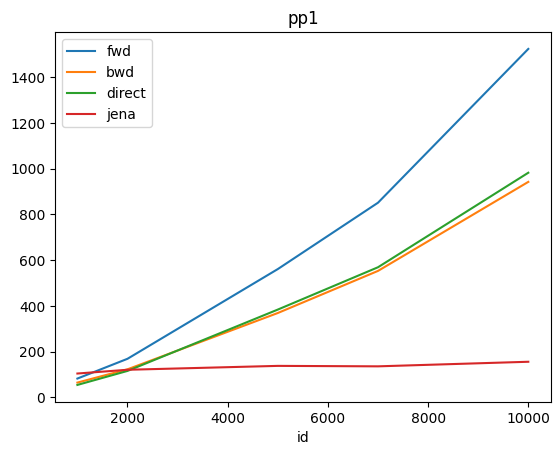

In [149]:
plot_query("pp1", incl_only=['n3_dir', 'n3_bwd', 'n3_fwd','jena' ])

int64


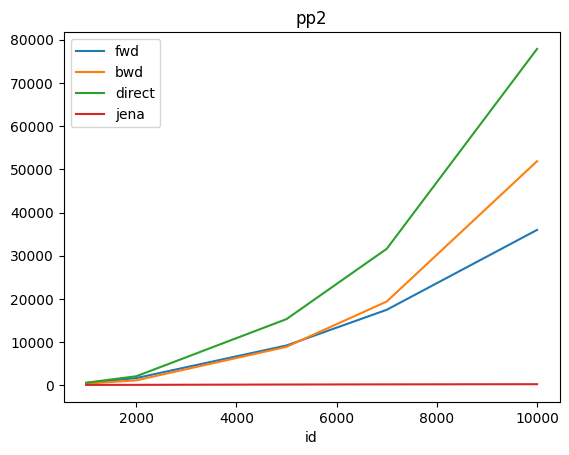

In [150]:
plot_query("pp2", incl_only=['n3_dir', 'n3_bwd', 'n3_fwd','jena' ])

int64


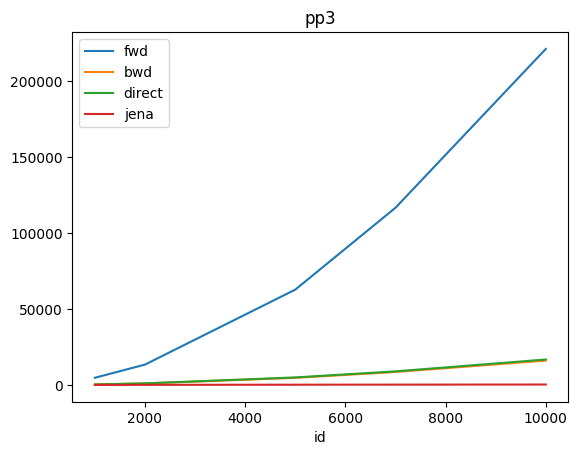

In [151]:
plot_query("pp3", incl_only=['n3_dir', 'n3_bwd','jena', 'n3_fwd' ])
# plot_query("pp3", incl_only=['n3_dir', 'n3_bwd','jena' ])

int64


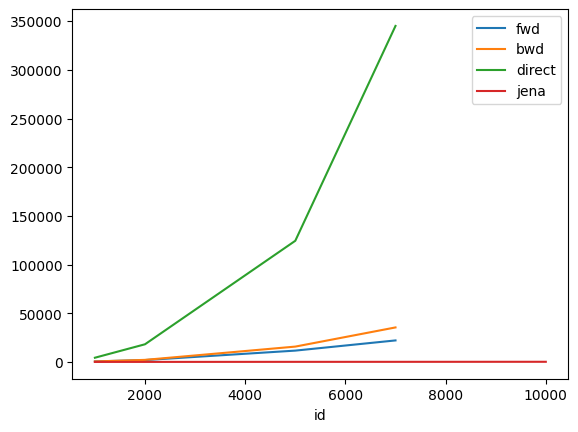

In [136]:
plot_query("pp4", incl_only=['n3_dir', 'n3_bwd','jena', 'n3_fwd' ])
# plot_query("pp4", incl_only=['n3_bwd','jena', 'n3_fwd' ])

int64


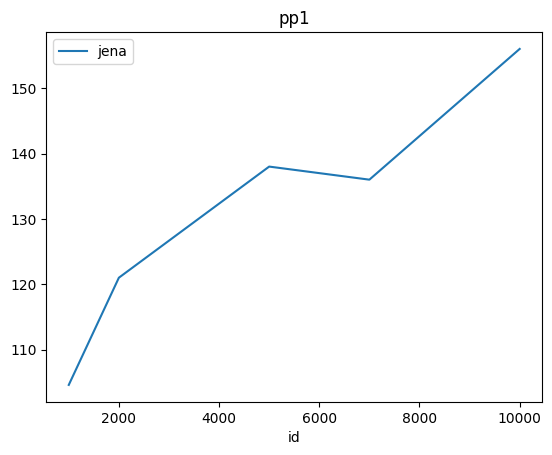

In [8]:
plot_query("pp1", incl_only=['jena' ])

int64


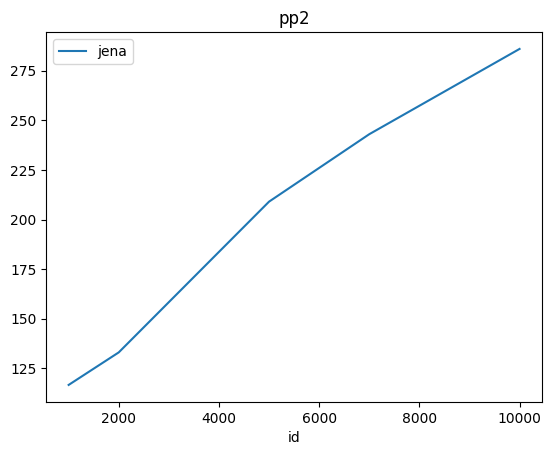

In [9]:
plot_query("pp2", incl_only=['jena' ])

int64


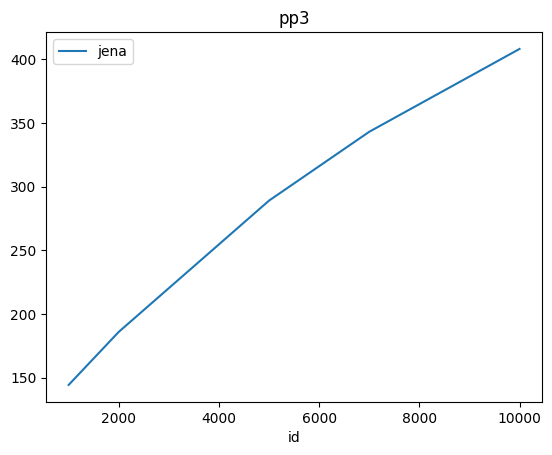

In [10]:
plot_query("pp3", incl_only=['jena' ])

int64


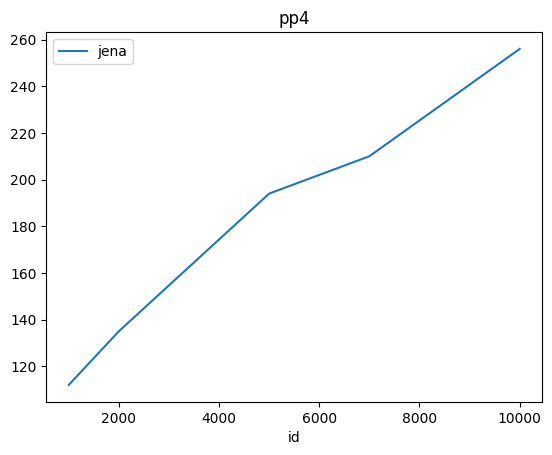

In [11]:
plot_query("pp4", incl_only=['jena' ])

In [86]:
import matplotlib.pyplot as plt

def plot_dataset(data_size, lim=None, incl_only=['n3_dir', 'n3_bwd', 'n3_fwd','jena', 'rdflib', 'rdf4j']):
    fig, ax = plt.subplots()
    if lim is not None:
        ax.set_ylim(0, lim)

    if 'n3_fwd' in incl_only:
        load_n3_agg_dataset('fwd', data_size).plot(x='id', y='reas_time', ax=ax, label='fwd')
    if 'n3_bwd' in incl_only:
        load_n3_agg_dataset('bwd', data_size).plot(x='id', y='reas_time', ax=ax, label='bwd')
    if 'n3_dir' in incl_only:
        load_n3_agg_dataset('direct', data_size).plot(x='id', y='reas_time', ax=ax, label='direct')

    if 'jena' in incl_only:
        load_sparql_agg_dataset('jena', data_size).plot(x='id', y='exec_time', ax=ax, label='jena')
    if 'rdflib' in incl_only:
        load_sparql_agg_dataset('rdflib', data_size).plot(x='id', y='exec_time', ax=ax, label='rdflib')
    if 'rdf4j' in incl_only:
        load_sparql_agg_dataset('rdf4j', data_size).plot(x='id', y='exec_time', ax=ax, label='rdf4j')

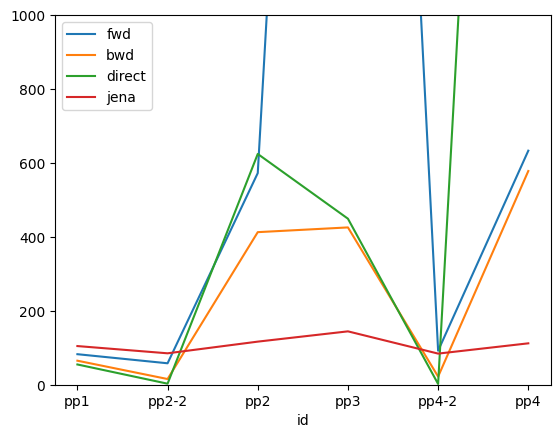

In [89]:
plot_dataset("1_000_pt2", lim=1000, incl_only=['n3_dir', 'n3_bwd', 'n3_fwd','jena' ])

In [ ]:
plot_dataset(50, lim=500, incl_only=['n3_fwd', 'jena', 'rdf4j'])

In [ ]:
plot_dataset(100, lim=1000, incl_only=['n3_fwd', 'jena', 'rdf4j'])